In [226]:
import missingno as msno
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import seaborn as sns
import nltk
import joblib
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\swiif\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1. EDA

In [227]:
df = pd.read_csv('../data/clickbait_title_classification.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      32000 non-null  object
 1   clickbait  32000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 500.1+ KB


In [228]:
df.head()

,title,clickbait
0,""".asia"" domain applications near 300,000 on op...",0
1,"""1 Indian + 1 Indian = Unrelatable"": Televisio...",1
2,"""7th Heaven"" television series comes to an end",0
3,"""Arm Glow"" Is Your New Life Goal, Thanks To Lu...",1
4,"""Beans Memes"" Is The Only Twitter Account That...",1


In [229]:
if df.isnull().values.any():
    print(f"There are {df.isna().sum()} missing values in the dataset.")
    msno.matrix(df)
else:
    print("No missing values found in the dataset.")

No missing values found in the dataset.


In [230]:
if df.duplicated().any():
    print(f"There are {df.duplicated().sum()} duplicate rows in the dataset.")#
    df = df.drop_duplicates()
else:
    print("No duplicate rows found in the dataset.")

No duplicate rows found in the dataset.


<Figure size 800x500 with 0 Axes>

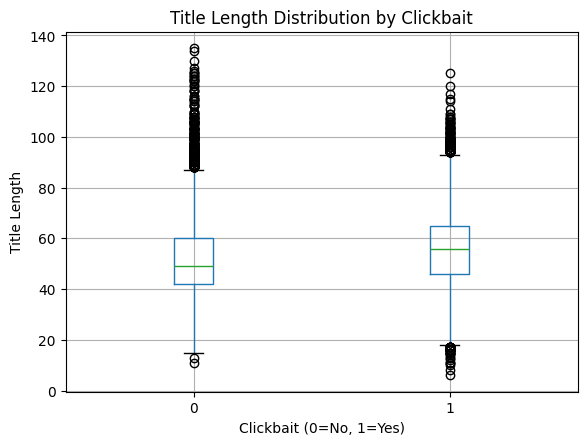

In [231]:
if 'title_length' not in df.columns:
	df['title_length'] = df['title'].str.len()

plt.figure(figsize=(8, 5))
df.boxplot(column='title_length', by='clickbait')
plt.xlabel('Clickbait (0=No, 1=Yes)')
plt.ylabel('Title Length')
plt.title('Title Length Distribution by Clickbait')
plt.suptitle('')
plt.show()

Interesting there are some really short titles.

In [232]:
df[df['title_length'] < 17].head(10)

,title,clickbait,title_length
5778,33 Bad Puns,1,11
6507,9 Period Hacks,1,14
6539,9 Times I Cried,1,15
7873,Are Emojis Words,1,16
7931,Are You Dead,1,12
8788,BFWKND,1,6
9780,COCK BLOCK,1,10
11510,DIY Sugar Wax,1,13
11985,Do You Have ESP,1,15
14408,Goys Try Latkes,1,15


In [233]:
df[df['title_length'] > 120].head(10)

,title,clickbait,title_length
8673,Australian rules football: West Gippsland Latr...,0,126
9866,"Cambridge, Mass., city council recommends cons...",0,127
10617,Catholic Democrats tell Chicago Cardinal Georg...,0,125
10664,"Champaign, Illinois mayor doubts Obama's natur...",0,123
11156,Common Sense Advisory announces size of worldw...,0,135
12574,England; Australia set to battle for right to ...,0,124
18301,Liberal Democrats defeated in UK elections aft...,0,130
20763,Opposition motions in Australian House of Repr...,0,125
20969,Palestinian security forces clash with militan...,0,122
24516,Teen charged with seven felonies related to th...,0,125


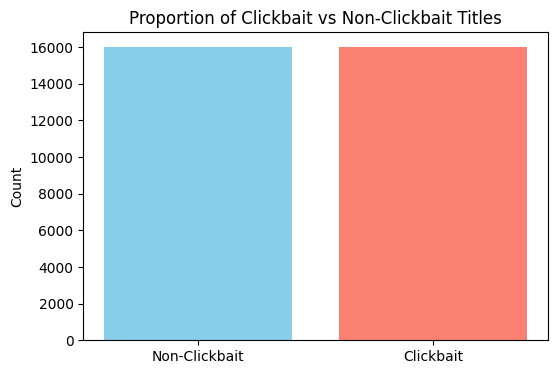

In [234]:
clickbait_counts = df['clickbait'].value_counts()
plt.figure(figsize=(6, 4))
plt.bar(['Non-Clickbait', 'Clickbait'], clickbait_counts, color=['skyblue', 'salmon'])
plt.ylabel('Count')
plt.title('Proportion of Clickbait vs Non-Clickbait Titles')
plt.show()

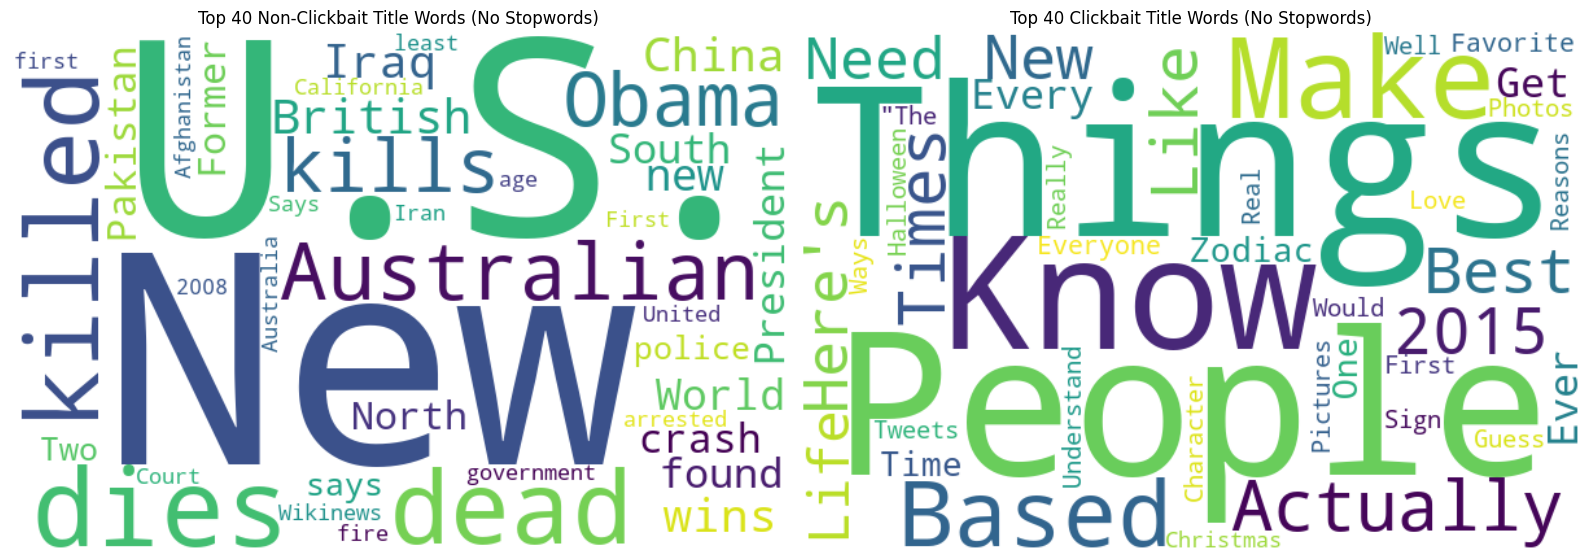

In [235]:
top_n = 40  # Change this value for more or fewer words

stop_words = set(stopwords.words('english'))

non_clickbait_titles = ' '.join(df[df['clickbait'] == 0]['title'])
words_non = [word for word in non_clickbait_titles.split() if len(word) > 2 and word.lower() not in stop_words]
wordcloud_non = WordCloud(width=600, height=400, background_color='white', max_words=top_n).generate_from_frequencies(Counter(words_non))

clickbait_titles = ' '.join(df[df['clickbait'] == 1]['title'])
words_click = [word for word in clickbait_titles.split() if len(word) > 2 and word.lower() not in stop_words]
wordcloud_click = WordCloud(width=600, height=400, background_color='white', max_words=top_n).generate_from_frequencies(Counter(words_click))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow(wordcloud_non, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title(f'Top {top_n} Non-Clickbait Title Words (No Stopwords)')
axes[1].imshow(wordcloud_click, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title(f'Top {top_n} Clickbait Title Words (No Stopwords)')
plt.tight_layout()
plt.show()

## 2. Data Engeneering

### Length of the Title

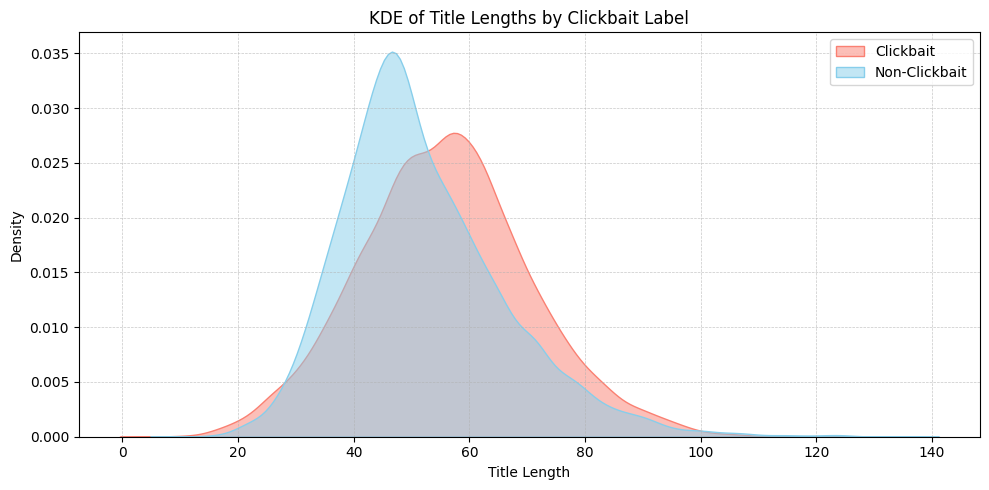

count    32000.000000
mean        53.804063
std         14.774600
min          6.000000
25%         44.000000
50%         52.000000
75%         63.000000
max        135.000000
Name: title_length, dtype: float64

In [236]:
if 'title_length' not in df.columns:
	df['title_length'] = df['title'].str.len()

plt.figure(figsize=(10, 5))
sns.kdeplot(df[df['clickbait'] == 1]['title_length'], fill=True, color='salmon', label='Clickbait', alpha=0.5)
sns.kdeplot(df[df['clickbait'] == 0]['title_length'], fill=True, color='skyblue', label='Non-Clickbait', alpha=0.5)

plt.title('KDE of Title Lengths by Clickbait Label')
plt.xlabel('Title Length')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

df['title_length'].describe()


### Number of Words in The Title

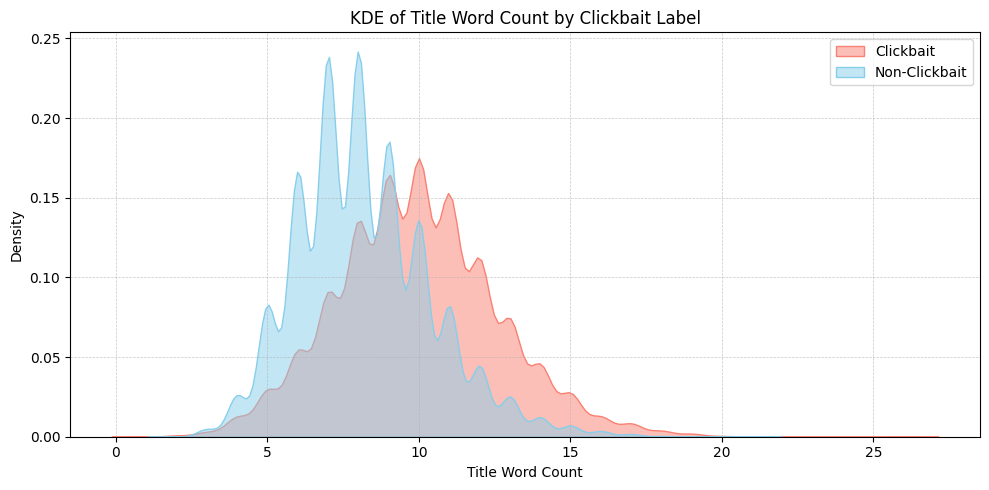

count    32000.000000
mean         9.065156
std          2.603603
min          1.000000
25%          7.000000
50%          9.000000
75%         11.000000
max         26.000000
Name: title_world_count, dtype: float64

In [237]:
if 'title_world_count' not in df.columns:
    df['title_world_count'] = df['title'].str.split().apply(len)
    
plt.figure(figsize=(10, 5))
sns.kdeplot(df[df['clickbait'] == 1]['title_world_count'], fill=True, color='salmon', label='Clickbait', alpha=0.5)
sns.kdeplot(df[df['clickbait'] == 0]['title_world_count'], fill=True, color='skyblue', label='Non-Clickbait', alpha=0.5)

plt.title('KDE of Title Word Count by Clickbait Label')
plt.xlabel('Title Word Count')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

df['title_world_count'].describe()

### Number Of Uppercase Worlds in Title

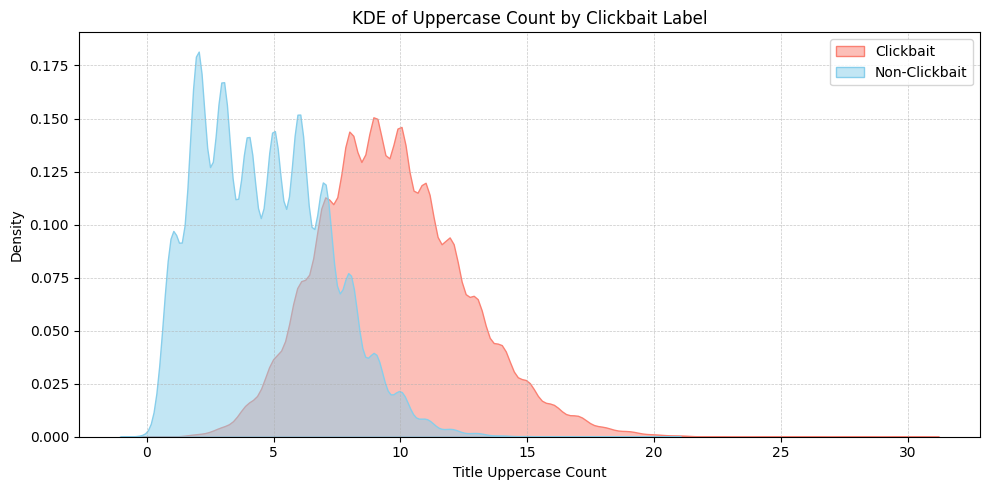

count    32000.000000
mean         7.159656
std          3.681163
min          0.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         30.000000
Name: title_uppercase_count, dtype: float64

In [238]:
if 'title_uppercase_count' not in df.columns:
    df['title_uppercase_count'] = df['title'].apply(lambda x: sum(1 for c in x if c.isupper()))
    
plt.figure(figsize=(10, 5))
sns.kdeplot(df[df['clickbait'] == 1]['title_uppercase_count'], fill=True, color='salmon', label='Clickbait', alpha=0.5)
sns.kdeplot(df[df['clickbait'] == 0]['title_uppercase_count'], fill=True, color='skyblue', label='Non-Clickbait', alpha=0.5)

plt.title('KDE of Uppercase Count by Clickbait Label')
plt.xlabel('Title Uppercase Count')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

df['title_uppercase_count'].describe()

### Number of Special Characters (Might Be Useful For This Dataset)

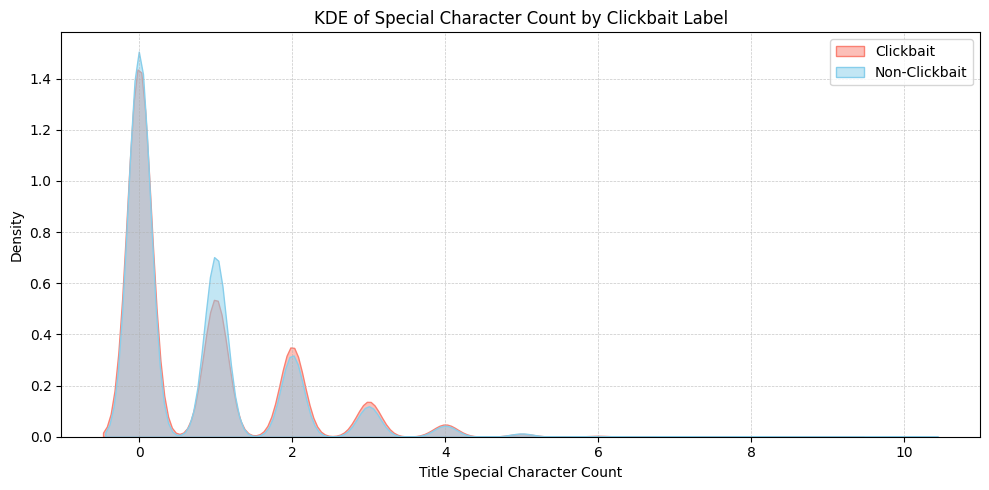

count    32000.000000
mean         0.744750
std          1.053687
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         10.000000
Name: number_of_special_characters, dtype: float64

In [239]:
if 'number_of_special_characters' not in df.columns:
    df['number_of_special_characters'] = df['title'].apply(lambda x: sum(1 for c in x if not c.isalnum() and not c.isspace()))
    
plt.figure(figsize=(10, 5))
sns.kdeplot(df[df['clickbait'] == 1]['number_of_special_characters'], fill=True, color='salmon', label='Clickbait', alpha=0.5)
sns.kdeplot(df[df['clickbait'] == 0]['number_of_special_characters'], fill=True, color='skyblue', label='Non-Clickbait', alpha=0.5)

plt.title('KDE of Special Character Count by Clickbait Label')
plt.xlabel('Title Special Character Count')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

df['number_of_special_characters'].describe()

### Has Numbers in the title

In [240]:
df['digit_count'] = df['title'].apply(lambda x: sum(1 for c in x if c.isdigit()))
print(df['digit_count'].value_counts().sort_index())

digit_count
0     21962
1       975
2      6766
3       487
4       968
5       159
6       589
7        33
8        44
9         7
10        9
16        1
Name: count, dtype: int64


count     32000
unique        2
top       False
freq      21962
Name: has_number, dtype: object

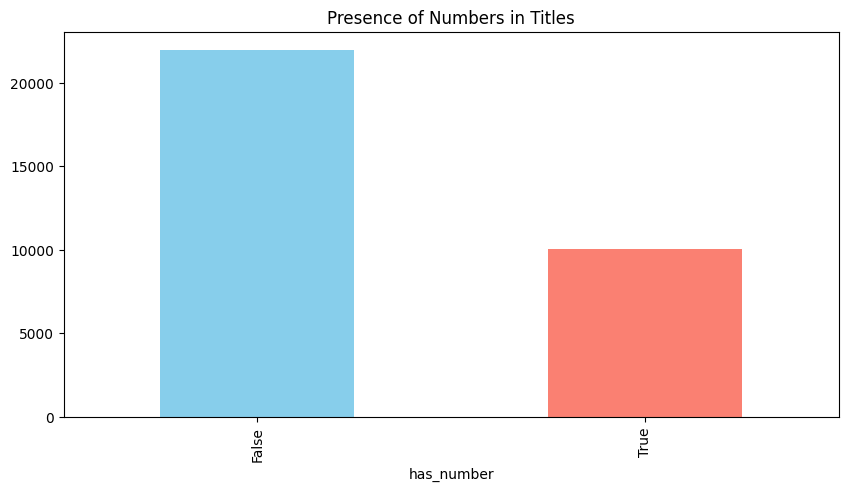

In [241]:
if 'has_number' not in df.columns:
    df['has_number'] = df['title'].str.contains(r'\d', na=False)
    
df['has_number'].value_counts().plot(kind='bar', figsize=(10, 5), color=['skyblue', 'salmon'], title='Presence of Numbers in Titles')
df['has_number'].describe()

### Uppercase Lowercase Ratio 

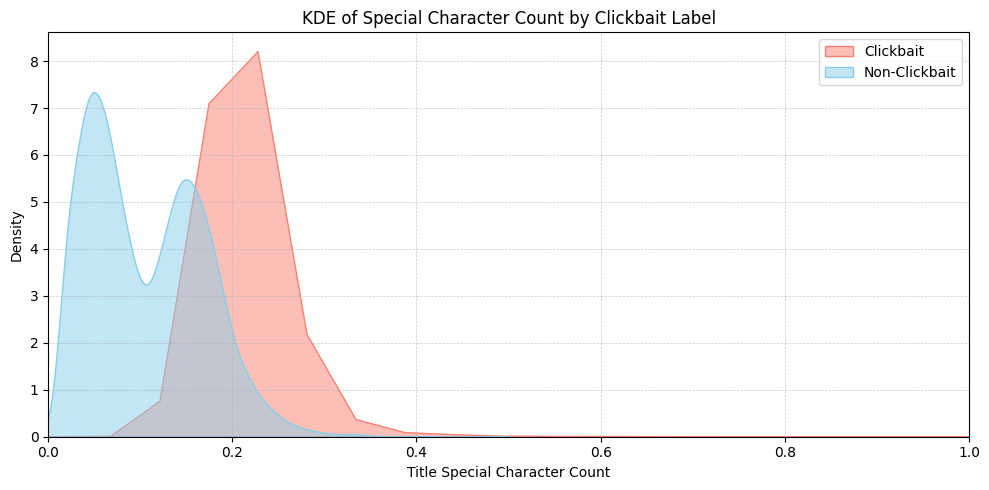

count    32000.000000
mean         0.160905
std          0.114880
min          0.000000
25%          0.097561
50%          0.173913
75%          0.212766
max         10.500000
Name: upper_lower_ratio, dtype: float64

In [242]:
if 'upper_lower_ratio' not in df.columns:
    df['upper_lower_ratio'] = df['title_uppercase_count'] / (df['title_length'] - df['title_uppercase_count']).replace(0, 1)

plt.figure(figsize=(10, 5))
sns.kdeplot(df[df['clickbait'] == 1]['upper_lower_ratio'], fill=True, color='salmon', label='Clickbait', alpha=0.5)
sns.kdeplot(df[df['clickbait'] == 0]['upper_lower_ratio'], fill=True, color='skyblue', label='Non-Clickbait', alpha=0.5)

plt.title('KDE of Special Character Count by Clickbait Label')
plt.xlabel('Title Special Character Count')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.xlim(0,1)
plt.tight_layout()
plt.show()

df['upper_lower_ratio'].describe()

### Starts with the Question

starts_with_question
False    29300
True      2700
Name: count, dtype: int64

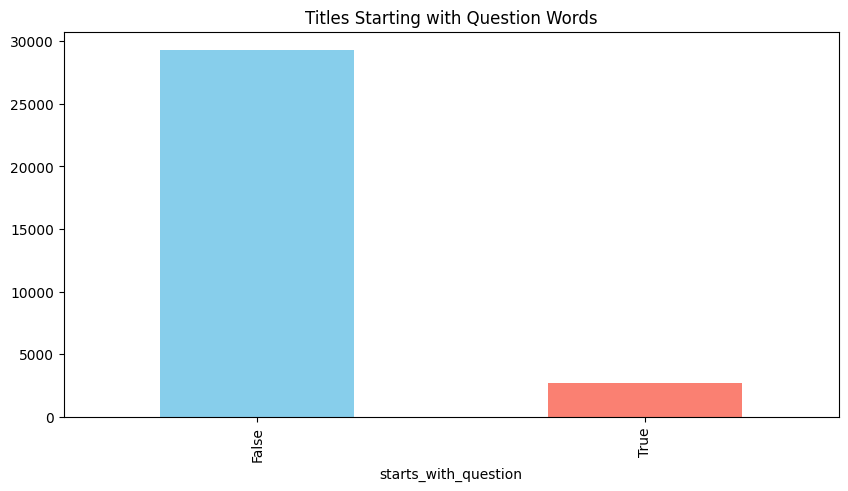

In [243]:
if 'starts_with_question' not in df.columns:
    questions = ['What', 'How', 'Why', 'Is', 'Are', 'Do', 'Does', 'Did', 'Can', 'Could', 'Will', 'Would']
    df['starts_with_question'] = df['title'].str.startswith(tuple(questions))
    
df['starts_with_question'].value_counts().plot(kind='bar', figsize=(10, 5), color=['skyblue', 'salmon'], title='Titles Starting with Question Words')
df['starts_with_question'].value_counts()

### Number of Superlatives (Not Useful For This Dataset)

count    32000.000000
mean         0.046938
std          0.214005
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: number_of_superlatives, dtype: float64

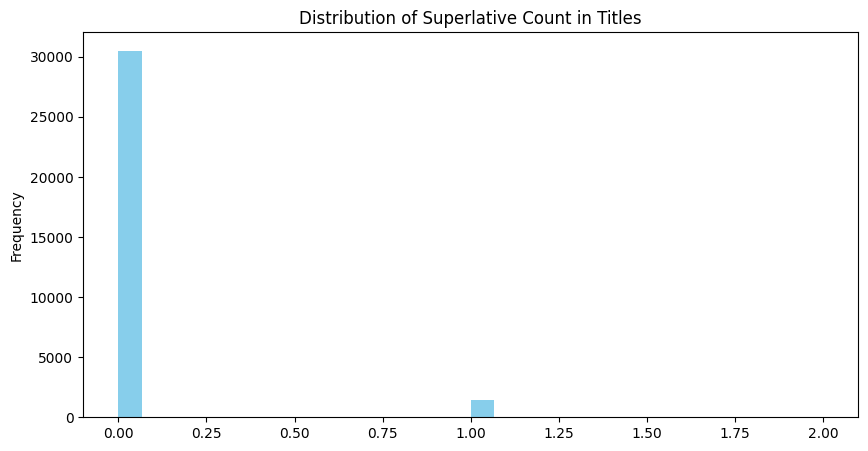

In [244]:
if 'number_of_superlatives' not in df.columns:
    superlatives = ['best', 'worst', 'greatest', 'most', 'least', 'biggest', 'smallest', 'highest', 'lowest', 'top', 'bottom']
    df['number_of_superlatives'] = df['title'].apply(lambda x: sum(1 for word in x.lower().split() if word in superlatives))
    
df['number_of_superlatives'].plot(kind='hist', bins=30, figsize=(10, 5), color='skyblue', title='Distribution of Superlative Count in Titles')
df['number_of_superlatives'].describe()



### Contains Exclamation (Not Useful For This Dataset)

count     32000
unique        2
top       False
freq      31962
Name: contains_exclamation, dtype: object

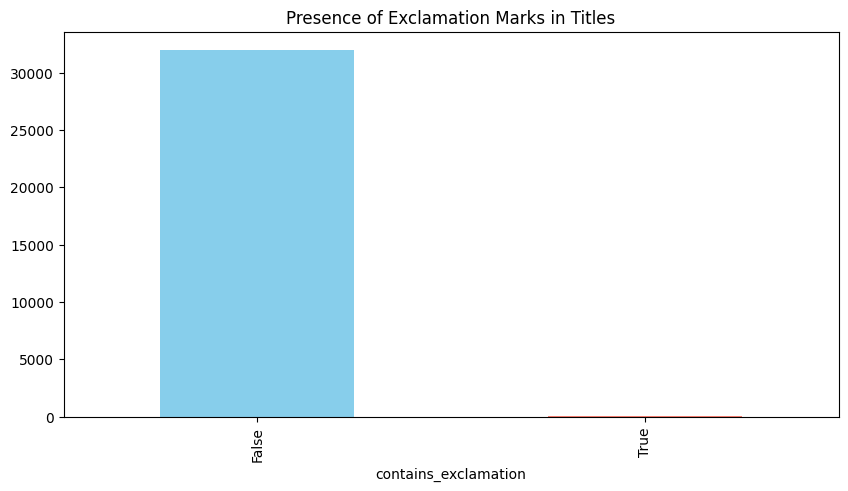

In [245]:
if 'contains_exclamation' not in df.columns:
    df['contains_exclamation'] = df['title'].str.contains('!', case=False, na=False)
    
df['contains_exclamation'].value_counts().plot(kind='bar', figsize=(10, 5), color=['skyblue', 'salmon'], title='Presence of Exclamation Marks in Titles')
df['contains_exclamation'].describe()

### Contains Question Marks (Not Useful For This Dataset)

count     32000
unique        2
top       False
freq      31840
Name: contains_question_mark, dtype: object

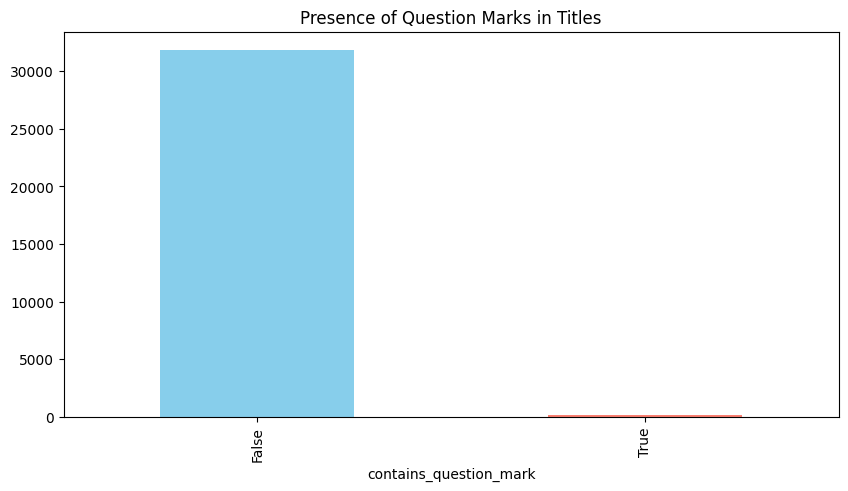

In [246]:
if 'contains_question_mark' not in df.columns:
    df['contains_question_mark'] = df['title'].str.contains('?', case=False, na=False, regex=False)

df['contains_question_mark'].value_counts().plot(kind='bar', figsize=(10, 5), color=['skyblue', 'salmon'], title='Presence of Question Marks in Titles')
df['contains_question_mark'].describe()

### Contains Quotation Marks (Might Be Useful For This Dataset)

count     32000
unique        2
top       False
freq      29430
Name: contains_quotation, dtype: object

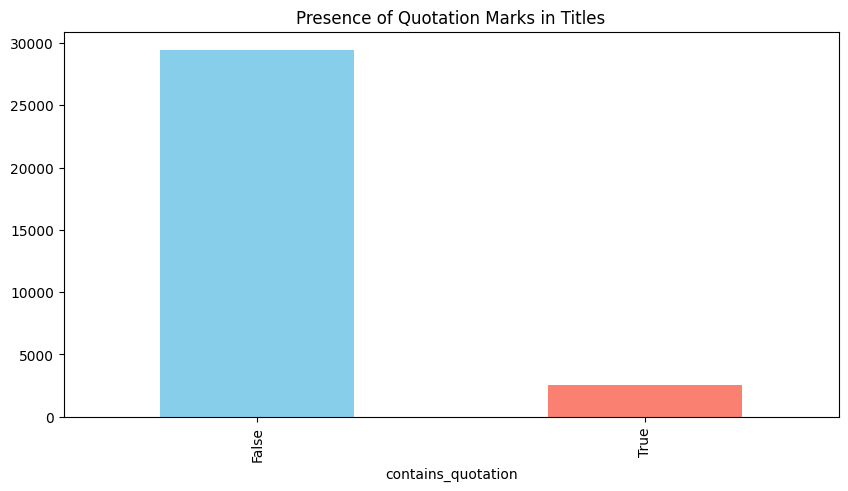

In [247]:
if 'contains_quotation' not in df.columns:
    df['contains_quotation'] = df['title'].str.contains('"', case=False, na=False)
    
df['contains_quotation'].value_counts().plot(kind='bar', figsize=(10, 5), color=['skyblue', 'salmon'], title='Presence of Quotation Marks in Titles')
df['contains_quotation'].describe()

### Contains Pronoun

count     32000
unique        2
top        True
freq      25077
Name: contains_pronoun, dtype: object

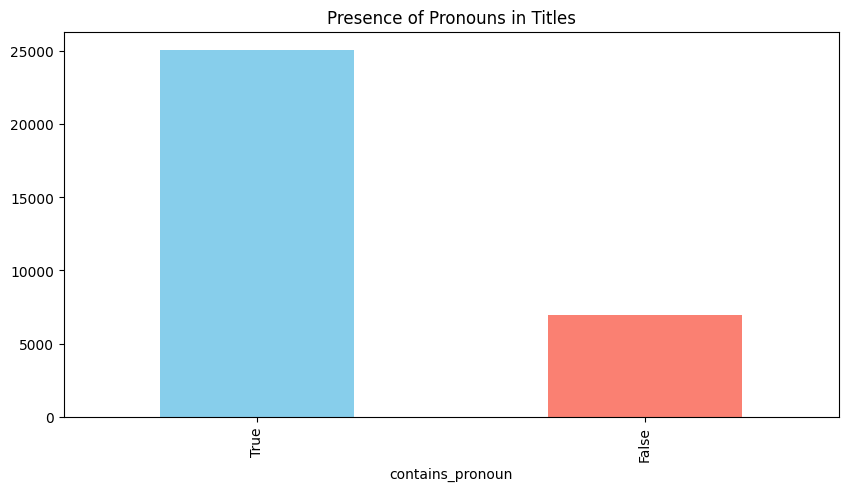

In [248]:
if 'contains_pronoun' not in df.columns:
    pronouns = ['I', 'me', 'my', 'you', 'your', 'he', 'him', 'his', 'she', 'her', 'it', 'its', 'we', 'us', 'our', 'they', 'them', 'their']
    df['contains_pronoun'] = df['title'].apply(lambda x: any(pronoun in x for pronoun in pronouns))

df['contains_pronoun'].value_counts().plot(kind='bar', figsize=(10, 5), color=['skyblue', 'salmon'], title='Presence of Pronouns in Titles')
df['contains_pronoun'].describe()

### Average Word Length

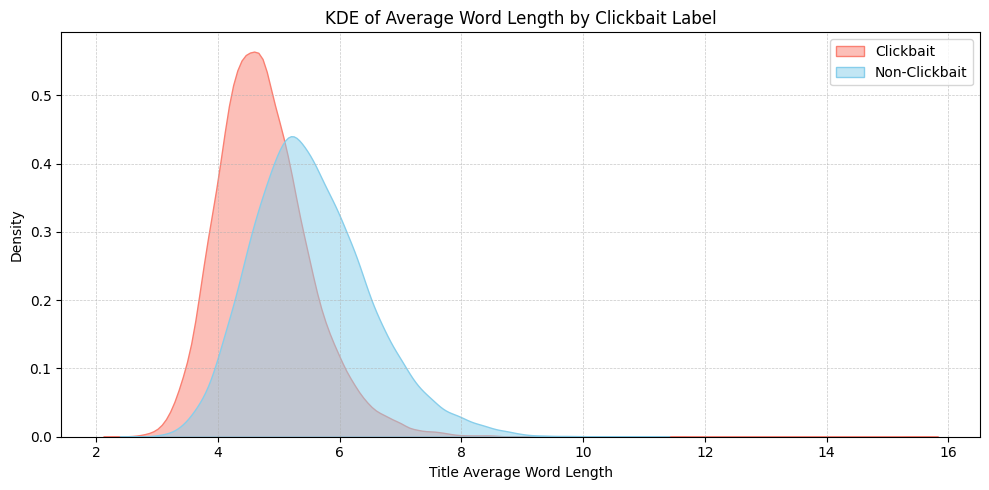

<bound method NDFrame.describe of 0        6.5556
1        5.5000
2        4.8750
3        4.3636
4        5.4000
          ...  
31995    6.4286
31996    6.2000
31997    4.5000
31998    6.2000
31999    4.8000
Name: average_word_length, Length: 32000, dtype: float64>

In [249]:
if 'average_word_length' not in df.columns:
    df['average_word_length'] = df['title'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()) if len(x.split()) > 0 else 0)
    df['average_word_length'] = df['average_word_length'].astype(float).round(4)
    
plt.figure(figsize=(10, 5))
sns.kdeplot(df[df['clickbait'] == 1]['average_word_length'], fill=True, color='salmon', label='Clickbait', alpha=0.5)
sns.kdeplot(df[df['clickbait'] == 0]['average_word_length'], fill=True, color='skyblue', label='Non-Clickbait', alpha=0.5)

plt.title('KDE of Average Word Length by Clickbait Label')
plt.xlabel('Title Average Word Length')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

df['average_word_length'].describe

In [250]:
boolean_columns = ['has_number', 'starts_with_question', 'contains_question_mark', 'contains_quotation', 'contains_pronoun']
df[boolean_columns] = df[boolean_columns].astype(int)

### Remove unnecessary columns

In [251]:
if 'upper_lower_ratio' in df.columns:
    del df['upper_lower_ratio']
if 'number_of_special_characters' in df.columns:
    del df['number_of_special_characters']
if 'number_of_superlatives' in df.columns:
    del df['number_of_superlatives']
if 'contains_exclamation' in df.columns:
    del df['contains_exclamation']
# if 'contains_question_mark' in df.columns:
#     del df['contains_question_mark']


In [252]:
df.head(10)

,title,clickbait,title_length,title_world_count,title_uppercase_count,digit_count,has_number,starts_with_question,contains_question_mark,contains_quotation,contains_pronoun,average_word_length
0,""".asia"" domain applications near 300,000 on op...",0,67,9,0,6,1,0,0,1,0,6.5556
1,"""1 Indian + 1 Indian = Unrelatable"": Televisio...",1,64,10,6,2,1,0,0,1,1,5.5000
2,"""7th Heaven"" television series comes to an end",0,46,8,1,1,1,0,0,1,1,4.8750
3,"""Arm Glow"" Is Your New Life Goal, Thanks To Lu...",1,58,11,11,0,0,0,0,1,1,4.3636
4,"""Beans Memes"" Is The Only Twitter Account That...",1,63,10,10,0,0,0,0,1,1,5.4000
5,"""Bigoted woman"": controversial Gordon Brown re...",0,65,9,3,0,0,0,0,1,0,6.3333
6,"""Black Mirror"" Creator On David Cameron's PigG...",1,81,13,14,0,0,0,0,1,1,5.3077
7,"""Black box"" found near crash site of Ethiopian...",0,62,10,3,0,0,0,0,1,1,5.3000
8,"""Black-ish"" Will Tackle The N-Word In Season P...",1,53,8,9,0,0,0,0,1,1,5.7500
9,"""Brooklyn"" Star Saoirse Ronan Actually Wants T...",1,64,10,10,0,0,0,0,1,0,5.5000


## 3. Machine Learning

### Naive Bayes 

In [253]:
X = df.title
y = df.clickbait

X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(X, y, test_size=.2, random_state=1)

vectorizer = TfidfVectorizer(max_features=10_000,ngram_range=(1, 2))

X_train_nbv = vectorizer.fit_transform(X_train_nb)
X_test_nbv = vectorizer.transform(X_test_nb)

In [254]:
modelNB = MultinomialNB()
modelNB.fit(X_train_nbv, y_train_nb)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [255]:
y_pred = modelNB.predict(X_test_nbv)

In [256]:
print(f'Accuracy: {accuracy_score(y_pred, y_test_nb)}')
print(f'Classification report:\n{classification_report(y_pred, y_test_nb)}')
print(f'Confusion matrix:\n{confusion_matrix(y_pred, y_test_nb)}')

Accuracy: 0.97140625
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3032
           1       0.98      0.97      0.97      3368

    accuracy                           0.97      6400
   macro avg       0.97      0.97      0.97      6400
weighted avg       0.97      0.97      0.97      6400

Confusion matrix:
[[2966   66]
 [ 117 3251]]


In [257]:
joblib.dump(modelNB, '../models/nb.joblib')

['../models/nb.joblib']

### Random Forest

In [258]:
X = df.iloc[:, 2:]
Y = df.clickbait

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, Y, test_size=.2, random_state=1)

In [259]:
modelRF = RandomForestClassifier()
modelRF.fit(X_train_rf, y_train_rf)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [260]:
modelRF.score(X_test_rf, y_test_rf)
y_pred = modelRF.predict(X_test_rf)

In [261]:
features = pd.DataFrame(modelRF.feature_importances_, index=X.columns, columns=['importance']).sort_values('importance', ascending=False)
features

,importance
title_uppercase_count,0.533710
average_word_length,0.103177
title_world_count,0.099675
title_length,0.081038
digit_count,0.078938
starts_with_question,0.037346
has_number,0.026013
contains_quotation,0.025655
contains_pronoun,0.011625
contains_question_mark,0.002823


In [262]:
print(f'Accuracy: {accuracy_score(y_pred, y_test_rf)}')
print(f'Classification report:\n{classification_report(y_pred, y_test_rf)}')
print(f'Confusion matrix:\n{confusion_matrix(y_pred, y_test_rf)}')


Accuracy: 0.94390625
Classification report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      3018
           1       0.96      0.94      0.95      3382

    accuracy                           0.94      6400
   macro avg       0.94      0.94      0.94      6400
weighted avg       0.94      0.94      0.94      6400

Confusion matrix:
[[2871  147]
 [ 212 3170]]


In [263]:
joblib.dump(modelRF, '../models/rf.joblib')

['../models/rf.joblib']

### Gradient Boost Classifier

In [264]:
X = df.iloc[:, 2:]
Y = df.clickbait

X_train_gb, X_test_gb, y_train_gb, y_test_gb = train_test_split(X, Y, test_size=.2, random_state=1)

In [265]:
modelGB = GradientBoostingClassifier()
modelGB.fit(X_train_gb, y_train_gb)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [266]:
modelGB.score(X_test_gb, y_test_gb)
y_pred = modelGB.predict(X_test_gb)

In [267]:
print(f'Accuracy: {accuracy_score(y_pred, y_test_gb)}')
print(f'Classification report:\n{classification_report(y_pred, y_test_gb)}')
print(f'Confusion matrix:\n{confusion_matrix(y_pred, y_test_gb)}')

Accuracy: 0.92984375
Classification report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      3044
           1       0.94      0.93      0.93      3356

    accuracy                           0.93      6400
   macro avg       0.93      0.93      0.93      6400
weighted avg       0.93      0.93      0.93      6400

Confusion matrix:
[[2839  205]
 [ 244 3112]]


In [268]:
joblib.dump(modelRF, '../models/gb.joblib')

['../models/gb.joblib']

### Combined Model

In [278]:
def combined_predict_soft(X_test_nb, X_test_rf, nb_weight=0.5, rf_weight=0.5):
    nb_proba = modelNB.predict_proba(vectorizer.transform(X_test_nb))[:, 1]
    rf_proba = modelRF.predict_proba(X_test_rf)[:, 1]
    # gb_proba = modelGB.predict_proba(X_test_gb)[:, 1]  
    
    combined_proba = nb_weight * nb_proba + rf_weight * rf_proba
    combined_pred = (combined_proba > 0.5).astype(int)
    
    return combined_pred, combined_proba

In [279]:
y_pred_soft, y_proba_soft = combined_predict_soft(X_test_nb, X_test_rf)

print(f'Accuracy: {accuracy_score(y_test_nb, y_pred_soft):.4f}')
print(f'Classification report:\n{classification_report(y_test_nb, y_pred_soft)}')

Accuracy: 0.9827
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3083
           1       0.98      0.99      0.98      3317

    accuracy                           0.98      6400
   macro avg       0.98      0.98      0.98      6400
weighted avg       0.98      0.98      0.98      6400



In [271]:
model_components = {
    'nb_model': modelNB,
    'rf_model': modelRF,
    'vectorizer': vectorizer,
    'feature_names': X_test_rf.columns.tolist()
}

joblib.dump(model_components, '../models/combined.joblib')


['../models/combined.joblib']

### Pytorch Deep Learning Model

## 4. Output and Test the Model

In [ ]:
def predict_clickbait(title, model_components, nb_weight=0.5, rf_weight=0.5):

    questions = ['What', 'How', 'Why', 'Is', 'Are', 'Do', 'Does', 'Did', 'Can', 'Could', 'Will', 'Would']
    pronouns = ['I', 'me', 'my', 'you', 'your', 'he', 'him', 'his', 'she', 'her', 'it', 'its', 'we', 'us', 'our', 'they', 'them', 'their']
    
    modelNB = model_components['nb_model']
    modelRF = model_components['rf_model']
    vectorizer = model_components['vectorizer']
    feature_names = model_components['feature_names']
    
    features = {
        'title_length': len(title),
        'title_world_count': len(title.split()),
        'title_uppercase_count': sum(1 for c in title if c.isupper()),
        'digit_count': sum(1 for c in title if c.isdigit()),
        'has_number': any(c.isdigit() for c in title),
        'starts_with_question': title.startswith(tuple(questions)),
        'contains_question_mark': '?' in title,
        'contains_quotation': '"' in title,
        'contains_pronoun': any(pronoun in title for pronoun in pronouns),
        'average_word_length': sum(len(word) for word in title.split()) / len(title.split()) if len(title.split()) > 0 else 0
    }
    
    feature_array = [[features[col] for col in feature_names]]
    
    title_vec = vectorizer.transform([title])
    nb_proba = modelNB.predict_proba(title_vec)[0, 1]
    rf_proba = modelRF.predict_proba(feature_array)[0, 1]
    
    combined_proba = nb_weight * nb_proba + rf_weight * rf_proba
    final_pred = 1 if combined_proba > 0.5 else 0
    
    return {
        'prediction': final_pred,
        'nb_probability': nb_proba,
        'rf_probability': rf_proba,
        'combined_probability': combined_proba
    }


In [288]:
test_titles = [
    "Google Cloud Associate Cloud Engineer Course - Pass the Exam!",
    "Scientists discover new method for treating cancer",
    "You Won't Believe What Happened Next!"
]

model_components = joblib.load('../models/combined.joblib')

for title in test_titles:
    result = predict_clickbait(title, model_components)
    print(f"\nTitle: {title}")
    print(f"NB Probability: {result['nb_probability']:.3f}")
    print(f"RF Probability: {result['rf_probability']:.3f}")
    print(f"Combined Probability: {result['combined_probability']:.3f}")


Title: Google Cloud Associate Cloud Engineer Course - Pass the Exam!
NB Probability: 0.260
RF Probability: 0.000
Combined Probability: 0.130

Title: Scientists discover new method for treating cancer
NB Probability: 0.161
RF Probability: 0.000
Combined Probability: 0.081

Title: You Won't Believe What Happened Next!
NB Probability: 0.998
RF Probability: 0.748
Combined Probability: 0.873


C:\Users\swiif\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\swiif\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\swiif\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
